In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster

In [2]:
info = pd.read_csv("ml-100k/u.info", sep=" ", header=None)
info.columns=['Counts', 'Type']
info

,Counts,Type
0,943,users
1,1682,items
2,100000,ratings


In [3]:
genre = pd.read_csv('ml-100k/u.genre', sep="|", encoding='latin-1', header=None)
genre.drop(genre.columns[1], axis=1, inplace=True)
genre.columns = ['Genres']
genre_list = list(genre['Genres'])
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [4]:
occupation = pd.read_csv('ml-100k/u.occupation', sep="|", encoding='latin-1', header=None)
occupation.columns = ['Occupations']
occupation_list = list(occupation['Occupations'])
occupation_list

['administrator',
 'artist',
 'doctor',
 'educator',
 'engineer',
 'entertainment',
 'executive',
 'healthcare',
 'homemaker',
 'lawyer',
 'librarian',
 'marketing',
 'none',
 'other',
 'programmer',
 'retired',
 'salesman',
 'scientist',
 'student',
 'technician',
 'writer']

In [5]:
data = pd.read_csv('ml-100k/u.data', sep="\t", header=None)
data.columns = ['user id', 'movie id', 'rating', 'timestamp']
print(data.shape)
data.head()

(100000, 4)


,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [6]:
item = pd.read_csv('ml-100k/u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
print(item.shape)
item.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
item['genres'] = item[['unknown', 'Action', 'Adventure', 'Animation', "Children's",
                                'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                                'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
                                'Sci-Fi', 'Thriller', 'War', 'Western']].apply(
                                    lambda row: '|'.join([col for col, val in row.items() if val == 1]),
                                    axis=1
                                )

In [8]:
item = item[item["movie title"] != "unknown"]

In [9]:
from datetime import datetime
def r_date_to_timestamp(date_string):
    date_format = "%d-%b-%Y"
    date_object = datetime.strptime(date_string, date_format)
    timestamp = (date_object - datetime(1970, 1, 1)).total_seconds()
    return timestamp

In [10]:
item["release_date_timestamp"] = item["release date"].apply(r_date_to_timestamp).astype(int)

In [11]:
user = pd.read_csv('ml-100k/u.user', sep="|", encoding='latin-1', header=None)
user.columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
print(user.shape)
user.head()

(943, 5)


,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [12]:
# tables = [data, item, user]
# for t in tables:
#     print("\n")
#     print(t.keys())
#     print(t.iloc[0])

In [13]:
keyspace_name = "movielens"

In [14]:
def connect_to_cassandra():
    cluster = Cluster(['127.0.0.1'])  # replace with your Cassandra cluster address
    session = cluster.connect()
    return cluster, session

def create_keyspace_and_use(session):
    session.execute("CREATE KEYSPACE IF NOT EXISTS movielens WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1}")
    session.execute(f"USE {keyspace_name}")

def close_connection(cluster):
    cluster.shutdown()

In [15]:
cluster, session = connect_to_cassandra()

create_keyspace_and_use(session)

In [16]:
def drop_all_tables_in_keyspace(cluster, keyspace_name):
    session = cluster.connect(keyspace_name)
    
    result = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = %s", (keyspace_name,))
    tables = [row.table_name for row in result]

    for table in tables:
        session.execute(f"DROP TABLE IF EXISTS {table}")

#drop_all_tables_in_keyspace(cluster, keyspace_name)

In [17]:
def get_table_schema(cluster, keyspace_name):
    session = cluster.connect(keyspace_name)
    
    result = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = %s", (keyspace_name,))
    tables = [row.table_name for row in result]

    for table in tables:
        result = session.execute(f"SELECT column_name, type FROM system_schema.columns WHERE keyspace_name = %s AND table_name = %s", (keyspace_name, table))
        schema = [(row.column_name, row.type) for row in result]

        print(f"Table: {table}")
        print("Schema:")
        for col_name, col_type in schema:
            print(f"  {col_name}: {col_type}")
        print("\n" + "-"*30)

In [18]:
def create_tables(session):
    session.execute("""
        CREATE TABLE IF NOT EXISTS users (
            user_id INT PRIMARY KEY,
            age INT,
            gender TEXT,
            occupation TEXT,
            zip_code TEXT
        )
    """)
    
    session.execute("""
        CREATE TABLE IF NOT EXISTS movies (
            movie_id INT,
            movie_title TEXT,
            release_date_timestamp BIGINT,
            genres SET<TEXT>,
            PRIMARY KEY (movie_id)
        )  
    """)
    
    session.execute("""
        CREATE TABLE IF NOT EXISTS movies_by_users (
            user_id INT,
            movie_id INT,
            rating INT,
            timestamp BIGINT,
            PRIMARY KEY ((movie_id), timestamp, user_id)
        )   WITH CLUSTERING ORDER BY (timestamp DESC)
    """)
    
    session.execute("""
        CREATE TABLE IF NOT EXISTS users_by_movies (
            user_id INT,
            movie_id INT,
            rating INT,
            timestamp BIGINT,
            PRIMARY KEY ((user_id), timestamp, movie_id)
        )   WITH CLUSTERING ORDER BY (timestamp DESC)

    """)

In [19]:
def prepare_insert_ratings(session):
    return session.prepare("INSERT INTO ratings (user_id, movie_id, rating, timestamp) VALUES (?, ?, ?, ?)")

def prepare_insert_movies(session):
    return session.prepare("""
        INSERT INTO movies (movie_id, movie_title, release_date_timestamp, genres)
        VALUES (?, ?, ?, ?)
    """)

def prepare_insert_users(session):
    return session.prepare("""
        INSERT INTO users (user_id, age, gender, occupation, zip_code)
        VALUES (?, ?, ?, ?, ?)
    """)

In [20]:
def insert_ratings_data_async(session, ratings_data, prepared_statement):
    for _, row in ratings_data.iterrows():
        session.execute_async(prepared_statement, (row['user id'], row['movie id'], row['rating'], row['timestamp']))

def insert_movies_data_async(session, movies_data, prepared_statement):
    for _, row in movies_data.iterrows():
        genres = set(row['genres'].split('|'))
        session.execute_async(prepared_statement, (row['movie id'], row['movie title'], int(row['release_date_timestamp']), genres))

def insert_users_data_async(session, users_data, prepared_statement):
    for _, row in users_data.iterrows():
        session.execute_async(prepared_statement, (row['user id'], row['age'], row['gender'], row['occupation'], row['zip code']))

def insert_movies_by_users(session, ratings_data, movies_data):
    de_normalized = pd.merge(ratings_data, movies_data, "left", "movie id")
    de_normalized = de_normalized[~de_normalized["movie title"].isna()]
    # to_upload = pd.concat([de_normalized[:1000], de_normalized[de_normalized["movie id"] == 23]]).drop_duplicates()
    for _, row in de_normalized.iterrows():
        session.execute_async("""
            INSERT INTO movies_by_users (user_id, movie_id, rating, timestamp)
            VALUES (%s, %s, %s, %s)
        """, (row['user id'], row['movie id'], row['rating'], row['timestamp']))
        
        session.execute_async("""
            INSERT INTO users_by_movies (user_id, movie_id, rating, timestamp)
            VALUES (%s, %s, %s, %s)
        """, (row['user id'], row['movie id'], row['rating'], row['timestamp']))
    return de_normalized

### Create Tables

In [21]:
create_tables(session)

In [22]:
result = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = %s", (keyspace_name,))
tables = [row.table_name for row in result]
print(tables)

['movies', 'movies_by_users', 'users', 'users_by_movies']


In [23]:
users_data = user.copy()
print(users_data.keys())
movies_data = item.copy()
print(movies_data.keys())
ratings_data = data.copy()
print(ratings_data.keys())

Index(['user id', 'age', 'gender', 'occupation', 'zip code'], dtype='object')
Index(['movie id', 'movie title', 'release date', 'video release date',
       'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children's',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'genres', 'release_date_timestamp'],
      dtype='object')
Index(['user id', 'movie id', 'rating', 'timestamp'], dtype='object')


In [24]:
insert_movies_statement = prepare_insert_movies(session)
insert_users_statement = prepare_insert_users(session)
# insert_ratings_statement = prepare_insert_ratings(session)

insert_movies_data_async(session, movies_data, insert_movies_statement)
insert_users_data_async(session, users_data, insert_users_statement)
# insert_ratings_data_async(session, ratings_data, insert_ratings_statement)

In [25]:
# create_tables(session)

In [26]:
_ = insert_movies_by_users(session, ratings_data, movies_data)

In [27]:
get_table_schema(cluster, keyspace_name)

Table: movies
Schema:
  genres: set<text>
  movie_id: int
  movie_title: text
  release_date_timestamp: bigint

------------------------------
Table: movies_by_users
Schema:
  movie_id: int
  rating: int
  timestamp: bigint
  user_id: int

------------------------------
Table: users
Schema:
  age: int
  gender: text
  occupation: text
  user_id: int
  zip_code: text

------------------------------
Table: users_by_movies
Schema:
  movie_id: int
  rating: int
  timestamp: bigint
  user_id: int

------------------------------


#### Quick Access to movie id averge rating!

In [28]:
result = session.execute("""
    SELECT movie_id, AVG(rating) AS avg_rating
    FROM movies_by_users
    WHERE movie_id = 117
""")
for row in result:
    print(row)

Row(movie_id=117, avg_rating=3)


### Recent Ratings For Movie

In [29]:
result = session.execute("""
    SELECT movie_id, rating, user_id, timestamp
    FROM movies_by_users
    WHERE movie_id = 117
    ORDER BY timestamp DESC
""")
for row in result:
    print(row)

Row(movie_id=117, rating=5, user_id=416, timestamp=893212930)
Row(movie_id=117, rating=5, user_id=532, timestamp=893119335)
Row(movie_id=117, rating=5, user_id=551, timestamp=892782807)
Row(movie_id=117, rating=5, user_id=714, timestamp=892777876)
Row(movie_id=117, rating=4, user_id=676, timestamp=892686244)
Row(movie_id=117, rating=5, user_id=56, timestamp=892679439)
Row(movie_id=117, rating=5, user_id=796, timestamp=892660283)
Row(movie_id=117, rating=4, user_id=517, timestamp=892659893)
Row(movie_id=117, rating=4, user_id=807, timestamp=892528813)
Row(movie_id=117, rating=2, user_id=234, timestamp=892334976)
Row(movie_id=117, rating=5, user_id=421, timestamp=892241624)
Row(movie_id=117, rating=5, user_id=280, timestamp=891700366)
Row(movie_id=117, rating=3, user_id=329, timestamp=891655868)
Row(movie_id=117, rating=5, user_id=253, timestamp=891628535)
Row(movie_id=117, rating=3, user_id=232, timestamp=891565128)
Row(movie_id=117, rating=5, user_id=223, timestamp=891549529)
Row(movie

### Movies with highest rating:
    

In [30]:
result = session.execute("""
    SELECT movie_id, AVG(cast(rating as double)) AS avg_rating, COUNT(rating) as cnt_rating
    FROM movies_by_users
    GROUP BY movie_id
""")

ratings = [(row.movie_id, row.avg_rating, row.cnt_rating) for row in result if row.cnt_rating > 250]
ratings_sorted = sorted(ratings, key=lambda x: (x[1], x[2]), reverse=True)
top_10_ratings = ratings_sorted[:10]
for movie_id, avg_rating, cnt_rating in top_10_ratings:
    result = session.execute(f"""
        SELECT movie_title, genres
        FROM movies
        WHERE movie_id = {movie_id}
    """)
    print("Movie ID:", movie_id, "Average Rating:", round(avg_rating, 2), "cnt_rating:", cnt_rating, result.one())

Movie ID: 318 Average Rating: 4.47 cnt_rating: 298 Row(movie_title="Schindler's List (1993)", genres=SortedSet(['Drama', 'War']))
Movie ID: 64 Average Rating: 4.45 cnt_rating: 283 Row(movie_title='Shawshank Redemption, The (1994)', genres=SortedSet(['Drama']))
Movie ID: 12 Average Rating: 4.39 cnt_rating: 267 Row(movie_title='Usual Suspects, The (1995)', genres=SortedSet(['Crime', 'Thriller']))
Movie ID: 50 Average Rating: 4.36 cnt_rating: 583 Row(movie_title='Star Wars (1977)', genres=SortedSet(['Action', 'Adventure', 'Romance', 'Sci-Fi', 'War']))
Movie ID: 357 Average Rating: 4.29 cnt_rating: 264 Row(movie_title="One Flew Over the Cuckoo's Nest (1975)", genres=SortedSet(['Drama']))
Movie ID: 98 Average Rating: 4.29 cnt_rating: 390 Row(movie_title='Silence of the Lambs, The (1991)', genres=SortedSet(['Drama', 'Thriller']))
Movie ID: 127 Average Rating: 4.28 cnt_rating: 413 Row(movie_title='Godfather, The (1972)', genres=SortedSet(['Action', 'Crime', 'Drama']))
Movie ID: 174 Average Ra

### Movie Trend analysis

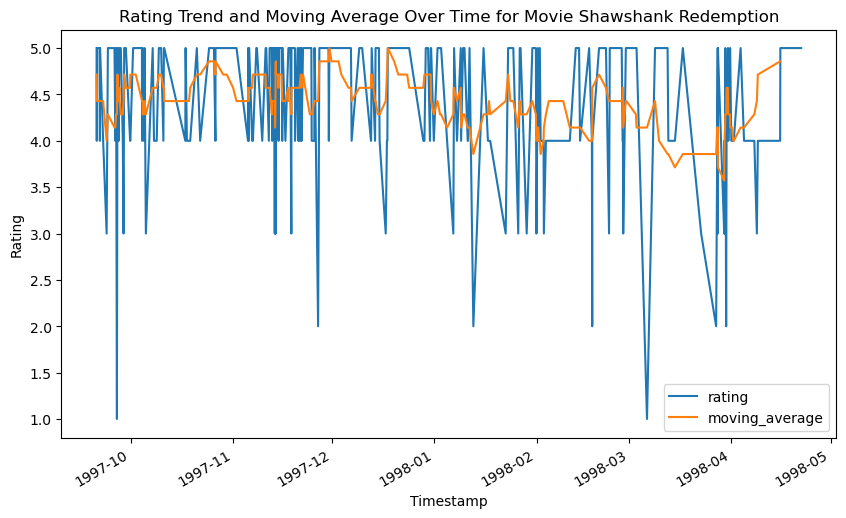

In [31]:
result = session.execute("""
    SELECT movie_id, rating, timestamp
    FROM movies_by_users
    WHERE movie_id = 64
""")
ratings = []
timestamps = []

for row in result:
    ratings.append(row.rating)
    timestamps.append(row.timestamp)

data = pd.DataFrame({'timestamp': timestamps, 'rating': ratings})
data['timestamp'] = pd.to_datetime(data['timestamp'], unit="s")
data.set_index('timestamp', inplace=True)
data['moving_average'] = data['rating'].rolling(window=7).mean()
data.plot(y=['rating', 'moving_average'], figsize=(10, 6), title='Rating Trend and Moving Average Over Time for Movie Shawshank Redemption')
plt.xlabel('Timestamp')
plt.ylabel('Rating')
plt.show()

### Recent Ratings Per User

In [32]:
result = session.execute("""
    SELECT user_id, movie_id, rating, timestamp
    FROM users_by_movies
    WHERE user_id = 13
    ORDER BY timestamp DESC
""")
for row in result:
    print(row)

Row(user_id=13, movie_id=914, rating=2, timestamp=892870589)
Row(user_id=13, movie_id=916, rating=4, timestamp=892870589)
Row(user_id=13, movie_id=918, rating=3, timestamp=892524090)
Row(user_id=13, movie_id=349, rating=1, timestamp=892387807)
Row(user_id=13, movie_id=891, rating=1, timestamp=892015288)
Row(user_id=13, movie_id=899, rating=1, timestamp=892015288)
Row(user_id=13, movie_id=889, rating=3, timestamp=892015236)
Row(user_id=13, movie_id=904, rating=1, timestamp=892015178)
Row(user_id=13, movie_id=911, rating=2, timestamp=892015141)
Row(user_id=13, movie_id=917, rating=4, timestamp=892015104)
Row(user_id=13, movie_id=915, rating=5, timestamp=892015023)
Row(user_id=13, movie_id=913, rating=1, timestamp=892014908)
Row(user_id=13, movie_id=912, rating=2, timestamp=892014861)
Row(user_id=13, movie_id=902, rating=3, timestamp=891749765)
Row(user_id=13, movie_id=906, rating=3, timestamp=891749765)
Row(user_id=13, movie_id=896, rating=5, timestamp=891036745)
Row(user_id=13, movie_id

### Top Active Users

In [33]:
result = session.execute("""
    SELECT user_id, COUNT(rating) AS num_ratings
    FROM users_by_movies
    GROUP BY user_id
""")
user_ratings = [(row.user_id, row.num_ratings) for row in result]
user_ratings_sorted = sorted(user_ratings, key=lambda x: x[1], reverse=True)
top_active_users = user_ratings_sorted[:10]
for user_id, num_ratings in top_active_users:
    print("User ID:", user_id, "Number of Ratings:", num_ratings)

User ID: 405 Number of Ratings: 737
User ID: 655 Number of Ratings: 685
User ID: 13 Number of Ratings: 636
User ID: 450 Number of Ratings: 540
User ID: 276 Number of Ratings: 518
User ID: 416 Number of Ratings: 493
User ID: 537 Number of Ratings: 490
User ID: 303 Number of Ratings: 484
User ID: 234 Number of Ratings: 480
User ID: 393 Number of Ratings: 448


### The Connection between occupation and rating

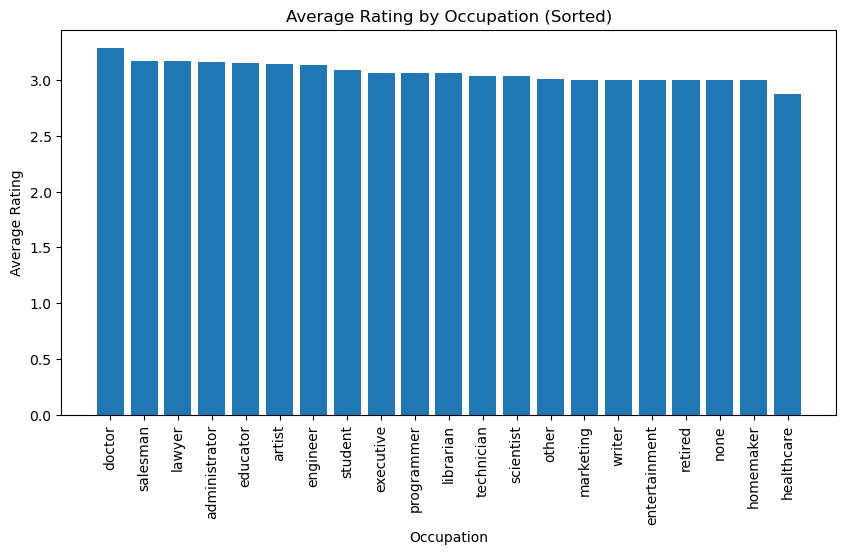

In [34]:
from collections import defaultdict
result = session.execute("""
    SELECT user_id, AVG(rating) AS avg_ratings
    FROM users_by_movies
    GROUP BY user_id
""")
user_ratings = [(row.user_id, row.avg_ratings) for row in result]

occ_to_avg_rating = defaultdict(list)

for user_id, avg_rating in user_ratings:
    result = session.execute(f"""
        SELECT occupation
        FROM users
        WHERE user_id = {user_id}
    """)
    occ_to_avg_rating[result.one()[0]].append(avg_rating)
    
avg_rating_by_occ = {occupation: sum(ratings) / len(ratings) for occupation, ratings in occ_to_avg_rating.items()}

sorted_avg_rating_by_occ = dict(sorted(avg_rating_by_occ.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.bar(sorted_avg_rating_by_occ.keys(), sorted_avg_rating_by_occ.values())
plt.xlabel('Occupation')
plt.ylabel('Average Rating')
plt.title('Average Rating by Occupation (Sorted)')
plt.xticks(rotation=90)
plt.show()